In [3]:
# Imports
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import os
import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [12]:
from matplotlib.collections import LineCollection
import glob
import joblib
import parameters as p
from utils import nodes2cell
from utils import convert_episodes_to_traj_class

In [339]:
labels = {
    'Animals':      'Animals',
    'TeAltOptions': '$\epsilon$$z$-Greedy',
    'BiasedWalk4':  'Biased Walk',
    'Uncertainty':  'Uncertainty',
    'RandomWalk':   'random',
    'Optimal':      'optimal',
}

In [5]:
figpath = '/Users/us3519/mouse-maze/figs/paper figs/figure_trajs'

In [99]:
def plt_trajectory(state_hist_all, episode_idx, save_file_name=None, title=None, display=True, figsize=(9,9), entry_exit_colorbar=False):
    '''
    Plots specified simulated trajectories on the maze layout.
    
    state_hist_all: list of trajectories simulated by a model.
        Eg. [[0,1,3..], [28, 57, 116, ..], [0, 2, ..]]
    episode_idx: 'all', to plot all trajectories in state_hist_all
             int, to plot a specific bout/episode with index episode_idx
    
    Plots One maze figure with plotted trajectories and a color bar indicating nodes from entry to exit
    Returns: None
    '''
    state_hist_cell, state_hist_xy = nodes2cell(state_hist_all)
    
    ma=NewMaze(6) # Draw the maze outline    
    fig,ax=plt.subplots(figsize=figsize)
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=2,yflip=True,
              xhide=True,yhide=True,axes=ax, title=None, alpha=1)

    re=[[-0.5,0.5,1,1],[-0.5,4.5,1,1],[-0.5,8.5,1,1],[-0.5,12.5,1,1],
       [2.5,13.5,1,1],[6.5,13.5,1,1],[10.5,13.5,1,1],
       [13.5,12.5,1,1],[13.5,8.5,1,1],[13.5,4.5,1,1],[13.5,0.5,1,1],
       [10.5,-0.5,1,1],[6.5,-0.5,1,1],[2.5,-0.5,1,1],
       [6.5,1.5,1,1],[6.5,11.5,1,1],[10.5,5.5,1,1],[10.5,7.5,1,1],
       [5.5,4.5,1,1],[5.5,8.5,1,1],[7.5,4.5,1,1],[7.5,8.5,1,1],[2.5,5.5,1,1],[2.5,7.5,1,1],
       [-0.5,2.5,3,1],[-0.5,10.5,3,1],[11.5,10.5,3,1],[11.5,2.5,3,1],[5.5,0.5,3,1],[5.5,12.5,3,1],
       [7.5,6.5,7,1]]  # coordinates of gray rectangles, the inaccessible regions of the maze

    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray', alpha=0.6)
        ax.add_patch(rect)
    ax.text(-1.2, 7.5, 'HOME', rotation='vertical')
    plt.axis('off')

    for id, epi in enumerate(state_hist_xy):
        x = epi[:,0]
        y = epi[:,1]
        t = np.linspace(0,1, x.shape[0]) # your "time" variable

        # set up a list of (x,y) points
        points = np.array([x,y]).transpose().reshape(-1,1,2)

        # set up a list of segments
        segs = np.concatenate([points[:-1],points[1:]],axis=1)

        # make the collection of segments
        lc = LineCollection(segs, cmap=plt.get_cmap('viridis'),linewidths=4) # jet, viridis hot
        lc.set_array(t) # color the segments by our parameter

#         # put a blue star in the beginning and a yellow star in the end of each trajectory
#         plt.plot(points[ 0, 0, 0], points[ 0, 0, 1], "*", markersize=10, color="blue")
#         plt.plot(points[-1, 0, 0], points[-1, 0, 1], "*", markersize=10, color="yellow")

        # plot the collection
        lines=ax.add_collection(lc); # add the collection to the plot

    # entry-exit colorbar
    if entry_exit_colorbar:
        cax=fig.add_axes([1.05, 0.05, 0.05, 0.9])
        cbar=fig.colorbar(lines,cax=cax)
        cbar.set_ticks([0,1])
        cbar.set_ticklabels(['Entry','Exit'])
        cbar.ax.tick_params(labelsize=30)

    ax.set_title(title, y=0.99, fontsize=50)
    if save_file_name:
        os.makedirs(os.path.dirname(save_file_name), exist_ok=True)
        plt.savefig(save_file_name, dpi=300, bbox_inches='tight', transparent=True)
    if display:
        plt.show()
    return

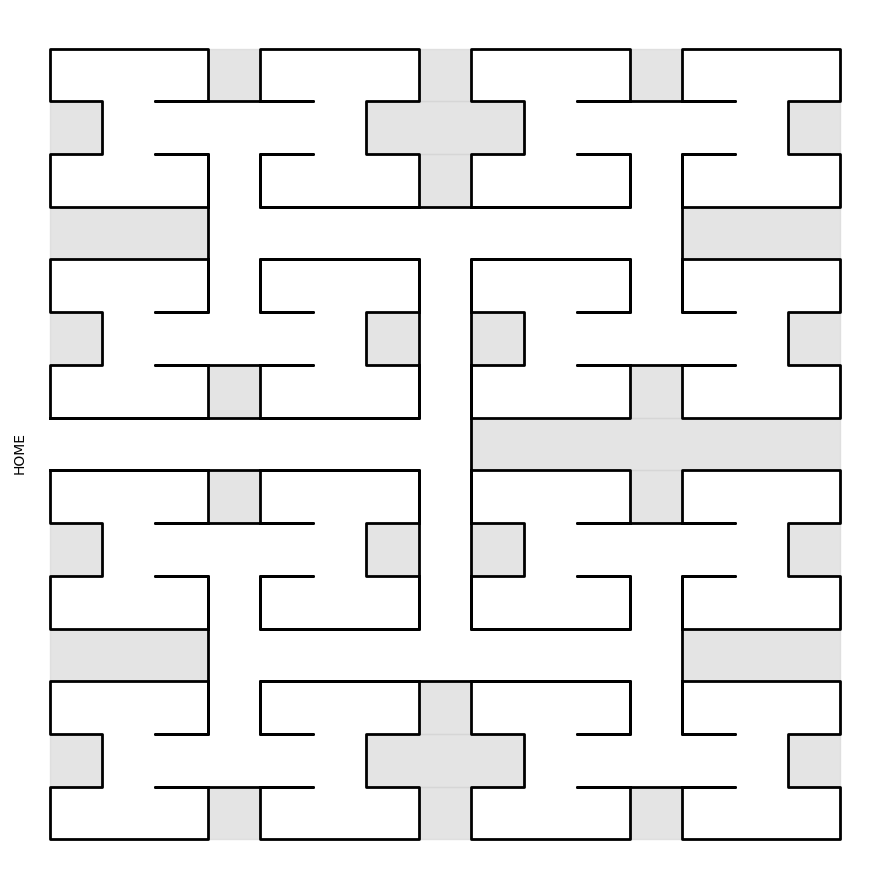

In [7]:
plt_trajectory([], 'all', save_file_name=f'{figpath}/empty_maze.pdf')

In [331]:
def load(model_name):
    if model_name == 'Animals':
        tfs = [LoadTrajFromPath(f'../outdata/{_}-tf') for _ in p.UnrewNamesSub]
        return tfs

#     if model_name == 'BiasedWalk':
#         tfs = [LoadTrajFromPath(f'/Users/us3519/newrosenberg/outdata/{_}-RW5-tf') for _ in p.UnrewNamesSub]
#         print('newrosenberg loaded for biasedwalk')
#         return tfs

#     if model_name == 'RandomWalk':
#         tfs = [LoadTrajFromPath('../outdata/rw01-tf')]
#         return tfs
    
    if model_name == 'MarkovChain':
        tfs = [LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{_}-MarkovSim-tf') for _ in p.UnrewNamesSub]
        return tfs

    tfs = []
    for f in glob.glob(f'/Users/us3519/mouse-maze/figs/may28/{model_name}/MAX_LENGTH=50000/**/episodes_*.pkl'):
        s = joblib.load(f)
        tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
        tfs.append(tf)
    return tfs

In [51]:
# model_name = 'TeAltOptions'
# tf = load(model_name)
# lens = np.array([len(_) for _ in tf[0].no])
# i=np.random.choice(np.where((lens > 150) & (lens < 200))[0])
# traj = tf[0].no[i][:, 0]
# print(i, len(traj))
# plt_trajectory([traj], 'all', 
#                save_file_name=f'{figpath}/{model_name}/{model_name}_{i}.pdf', 
#                title=f'{model_name}', 
#                entry_exit_colorbar=True,
#                display=False,
#               )

[ 0  1  0  2  0  1  4 10 22 46 94 46 93 46 22 10 21 43 87 43 87 43 88 43
 87 43 21 10 22 46 22 46 94 46 94 46 94 46 22 46 22 46 22 46 94 46 22 46
 94 46 94 46 22 45 92 45 91 45 22 10  4  9 20 41 84 41 83 41 20  9 19 39
 79 39 19 39 19 39 79 39 19 40 19 39 19  9  4  1  0  1  3  7 15  7  3  1
  4 10 22 46 94 46 22 46 94 46 93 46 22 46 22 46 94 46 22 10  4  9 20 41
 84 41 20  9  4 10 22 45 91 45 22 10  4  1  3  8 17 35 71 35 17 36 17 35
 17  8  3  7 15 32 66 32 65 32 15 32 66 32 15  7 16 34 70 34 16  7 15 31
 63 31 63 31 63 31 63 31 63 31 63 31 63 31 15 32 66 32 15  7  3  8 18 38
 78 38 18  8 17 36 73 36]


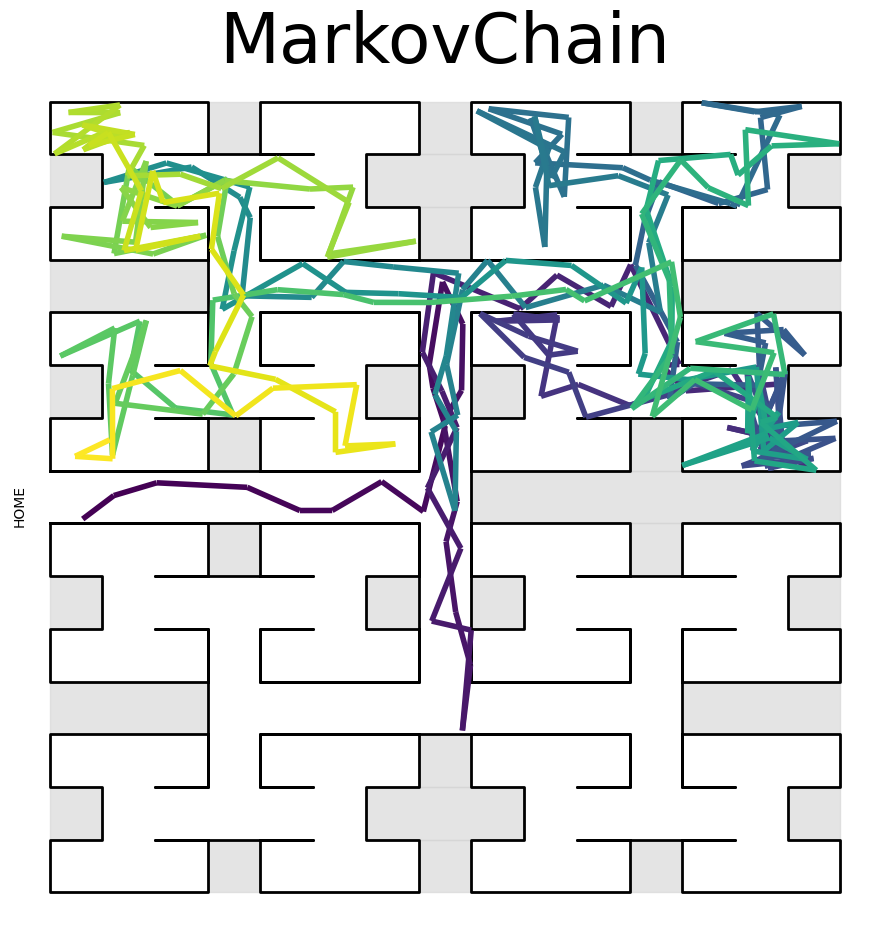

In [118]:
model_name = 'MarkovChain'
tf = load(model_name)
i=6
traj = tf[i].no[0][0:200, 0]
print(traj)
plt_trajectory([traj], 'all', 
               save_file_name=f'{figpath}/{model_name}/{model_name}_{i}.pdf', 
               title=f'{model_name}', 
               entry_exit_colorbar=False,
               display=False,
              )

Generating for TeAltOptions...
949


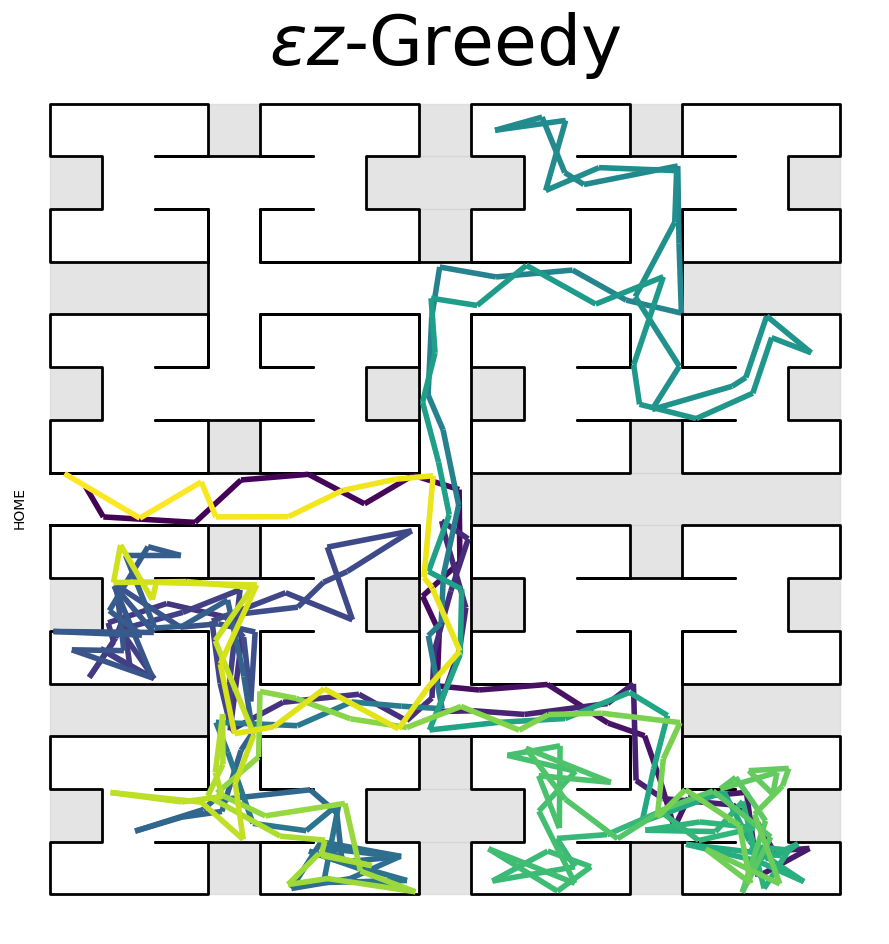

In [352]:
for model_name in ['TeAltOptions', 'RandomWalk', 'Uncertainty', 'Animals', 'BiasedWalk', 'BayesianQL', 'TeAltOptions', 'TeShortAltOptions', 'TeFixedActionOptions', 'TeLongAltOptions', 'TeRandomActionOptions']:
    tf = load(model_name)
    print(f"Generating for {model_name}...")
    atf = tf[10]
    lens = np.array([len(_) for _ in atf.no])
#     print(lens)
    minlen_tf_idxs = np.where((lens > 150) & (lens < 200))[0]
#     print(minlen_tf_idxs)
    if not minlen_tf_idxs.any():
        print(f"Empty for {model_name}")
        continue
    for i in np.random.choice(minlen_tf_idxs, size=5):
        print(i)
        traj = atf.no[i][:, 0]
        plt_trajectory([traj], 'all', 
                       save_file_name=f'{figpath}/{model_name}/{model_name}_{i}.pdf', 
                       title=f'{labels[model_name]}', 
                       entry_exit_colorbar=False, display=False)
        break
    print("=======")
    break

/var/folders/yx/80nc9b6n4pg69y4hhtmkpw100000gp/T/ipykernel_26743/2639865084.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


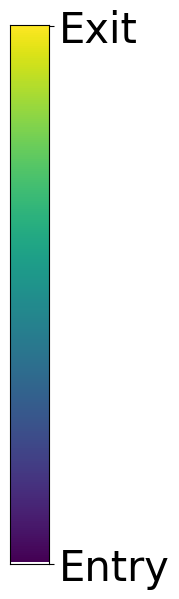

In [168]:
cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(0.5, 7))

# Dummy image to create colorbar
gradient = np.linspace(1, 0, 256).reshape(-1, 1)
img = ax.imshow(gradient, aspect='auto', cmap=cmap)

ax.get_xaxis().set_visible(False)
ax.set_yticks([256, 0])
ax.set_yticklabels(["Entry", "Exit"], fontsize=30)
ax.yaxis.tick_right()

plt.tight_layout()
plt.savefig(f'{figpath}/colorbar.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

(120, 128)
[[100.  19. 100. ... 100. 100. 100.]
 [ 62.  61. 100. ... 100. 100.  63.]
 [ 14.  13.  17. ...  64.  58.  15.]
 ...
 [ 10.   9.  45. ... 100.  50.  11.]
 [100.  35. 100. ... 100. 100. 100.]
 [ 20.  19.  21. ...  58.  56.  49.]]


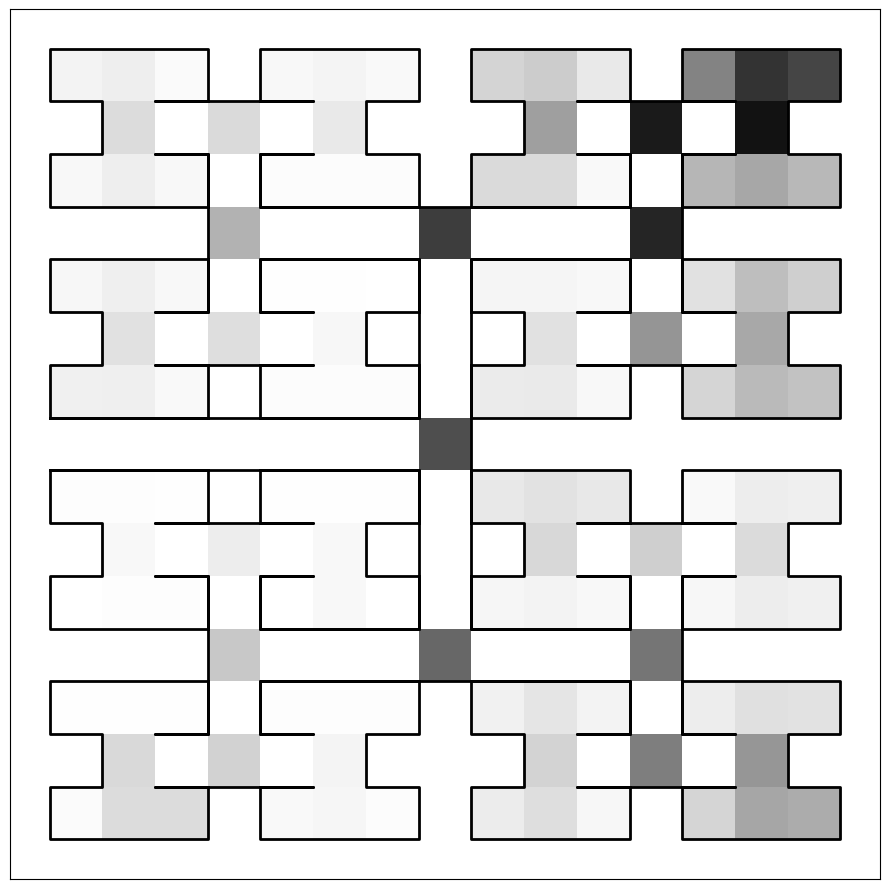

In [325]:
def firstvisit_heatmap(model_name, max_steps=10000):
    tfs = load(model_name)
    firstvisits = []
    for tf in tfs:
        t = 0
        traj = np.ones(128)*max_steps
        for b in tf.no:
            if len(b)<10:
                continue
            for n in b[:, 0]:
                traj[n] = min(t, traj[n])
                t += 1
            if t == max_steps:
                break
        firstvisits.append(traj)
    firstvisits = np.array(firstvisits)
    return firstvisits


def firstvisit_heatmap_animals(model_name, max_steps=10000):
    print("model_name", model_name)
    tfs = load(model_name)
    firstvisits = []
    print("tfs", len(tfs))
    for tf in tfs:
        for b in tf.no:
            ss = np.where(b[:, 0] == 41)[0]
            for s in ss:
                t = 0
                traj = np.ones(128)*max_steps
                for n in b[s:, 0]:
                    traj[n] = min(t, traj[n])
                    t += 1
                    if t >= max_steps:
                        break
                firstvisits.append(traj)        
    firstvisits = np.array(firstvisits)
    return firstvisits


model_name = 'TeAltOptions'
MAX = 100
if model_name in ['Animals', 'BayesianQL']:
    firstvisits = firstvisit_heatmap_animals(model_name, MAX)
else:
    firstvisits = firstvisit_heatmap(model_name, MAX)
mean_firstvisits = np.mean(firstvisits, axis=0)
norm_firstvisits = mean_firstvisits/np.max(mean_firstvisits)
print(firstvisits.shape)
print(firstvisits)


ma = NewMaze()
PlotMazeFunction(norm_firstvisits, ma, col=np.array([[0,0,0,0],[1,1,1,1]]), mode='nodes', numcol='', figsize=9)
# plt.savefig(f'{figpath}/firstvisits_corner/{model_name}_{MAX}.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

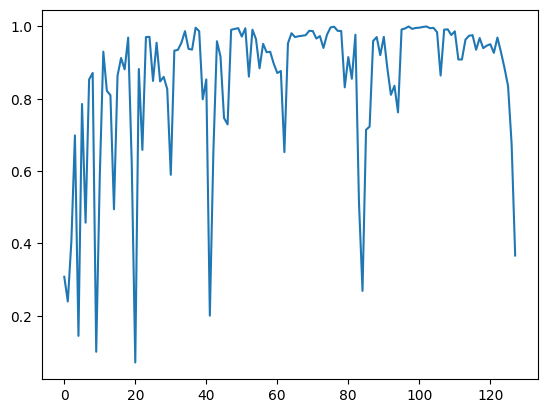

In [328]:
plt.plot(norm_firstvisits)
plt.show()

In [285]:
firstvisits[:, :10]

array([[ 83.,  82.,  84., ..., 100., 100.,  16.],
       [ 81.,  80.,  82., ..., 100., 100.,  14.],
       [ 69.,  68.,  70., ..., 100., 100.,   2.],
       ...,
       [100.,  42., 100., ...,  44.,  96.,  10.],
       [ 13.,  12.,  14., ..., 100., 100.,  10.],
       [ 11.,  10.,  12., ..., 100., 100.,   8.]])

/var/folders/yx/80nc9b6n4pg69y4hhtmkpw100000gp/T/ipykernel_35911/104632420.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


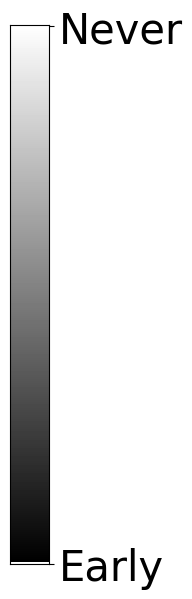

In [233]:
cmap = plt.get_cmap('gray')

fig, ax = plt.subplots(figsize=(0.5, 7))

# Dummy image to create colorbar
gradient = np.linspace(1, 0, 256).reshape(-1, 1)
img = ax.imshow(gradient, aspect='auto', cmap=cmap)

ax.get_xaxis().set_visible(False)
ax.set_yticks([256, 0])
ax.set_yticklabels(["Early", "Never"], fontsize=30)
ax.yaxis.tick_right()

plt.tight_layout()
plt.savefig(f'{figpath}/firstvisits_corner/colorbar.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

<Axes: >

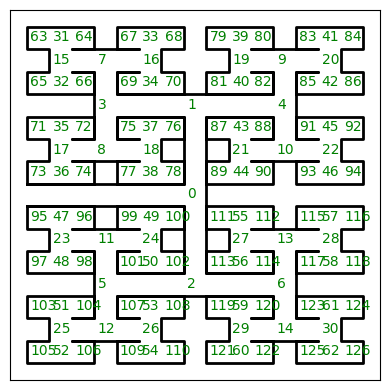

In [127]:
PlotMazeFunction([0]*127, ma, mode='nodes', numcol='g')

Generating for TeFixedActionOptions...
236
1158
742
561
640
Generating for TeRandomActionOptions...
32
127
175
15
180


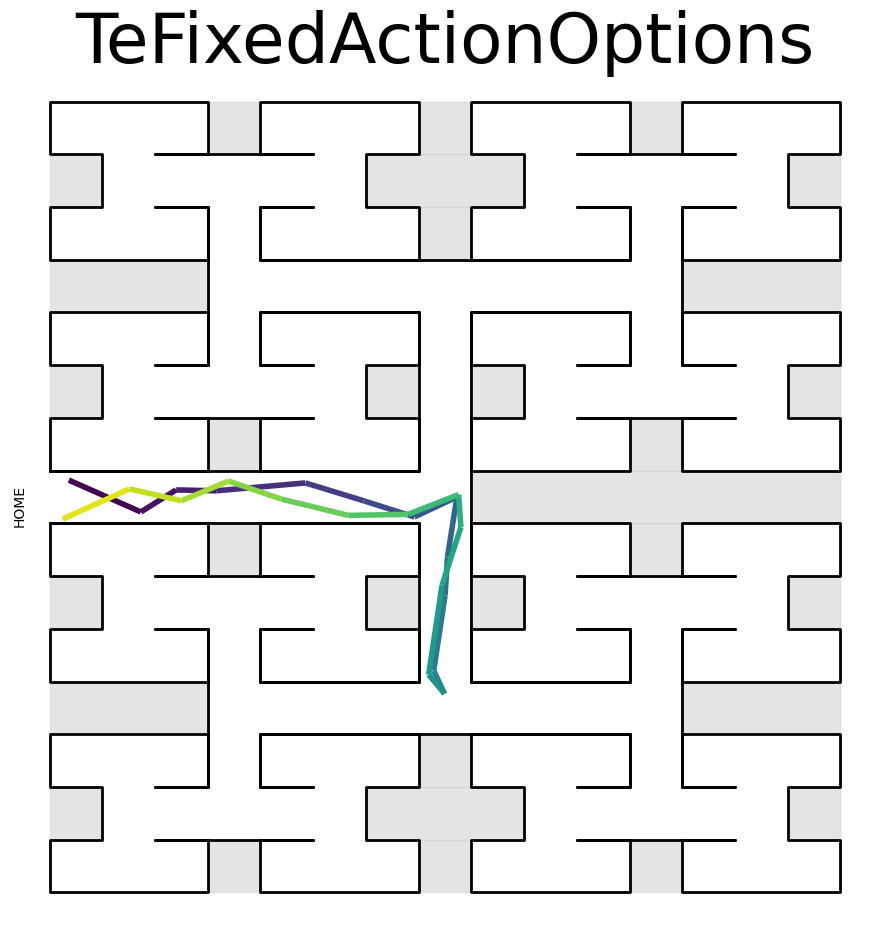

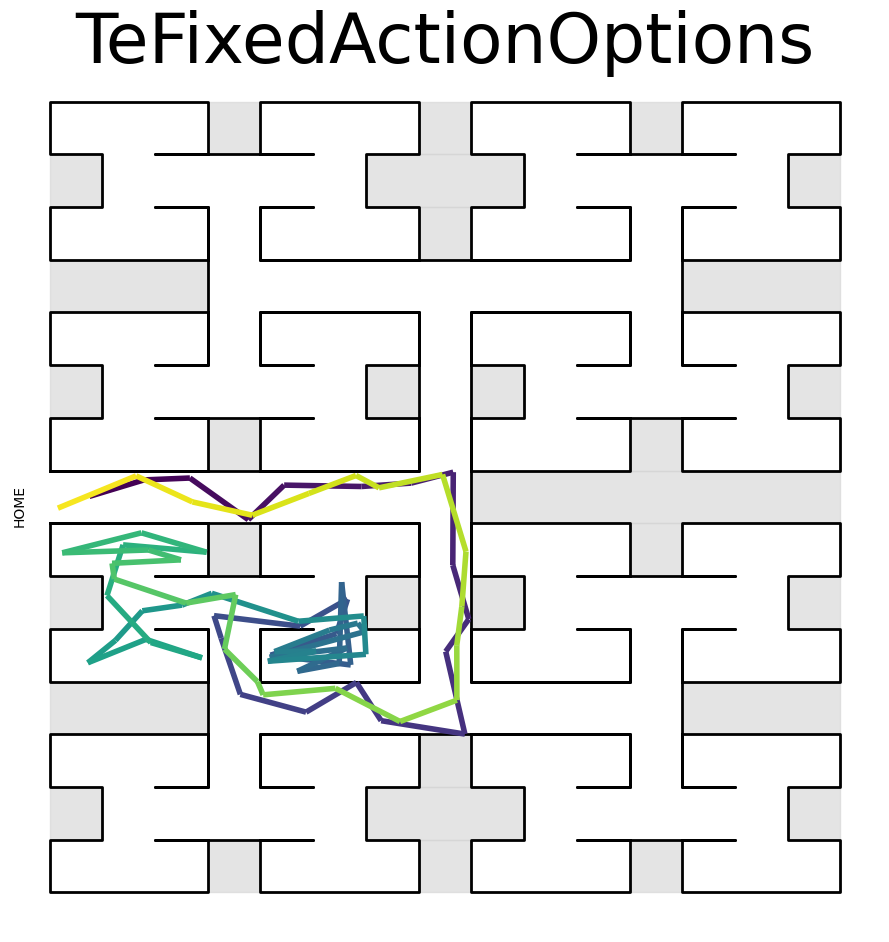

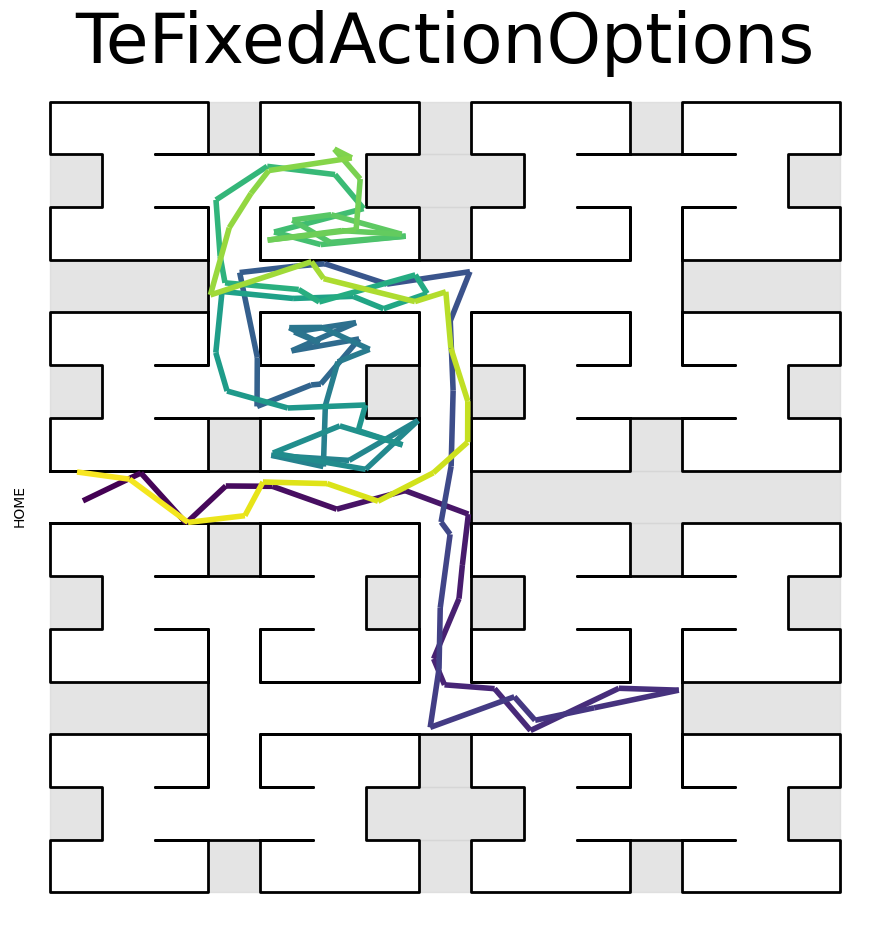

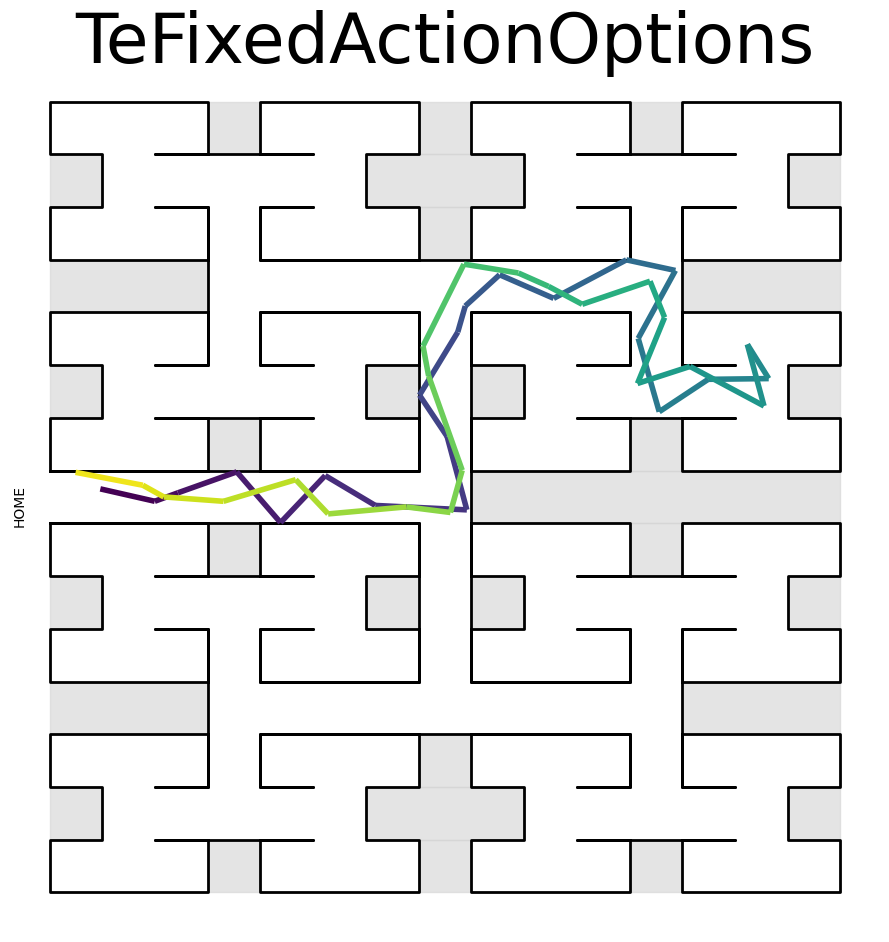

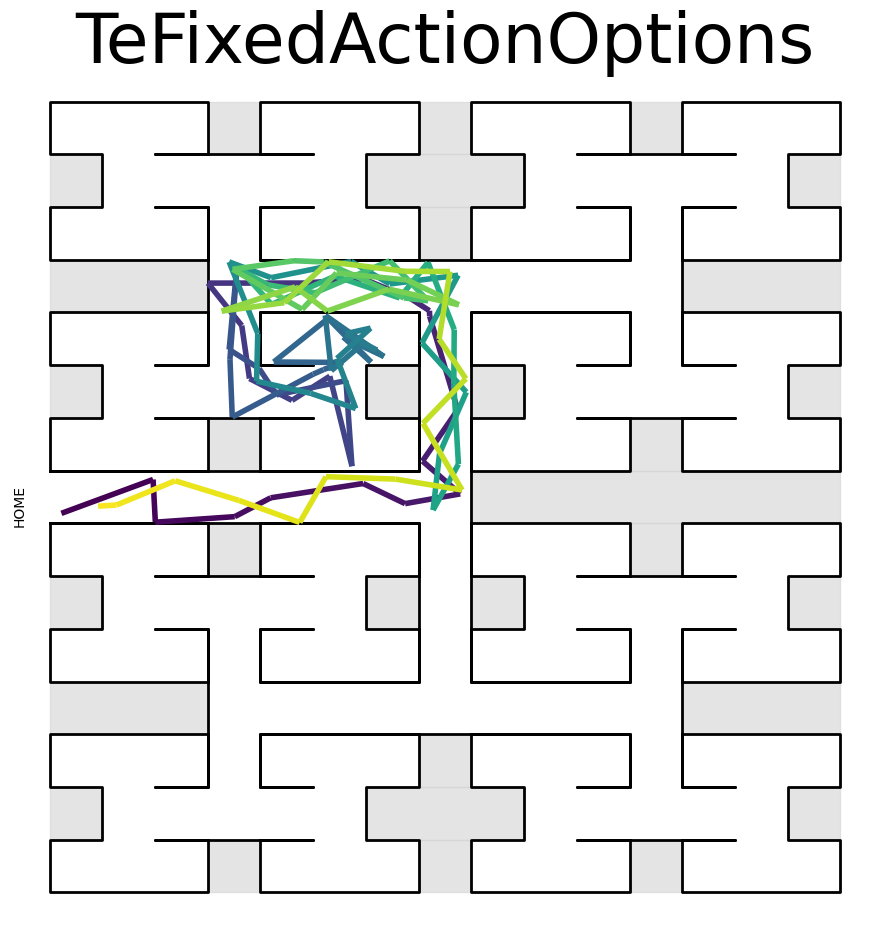

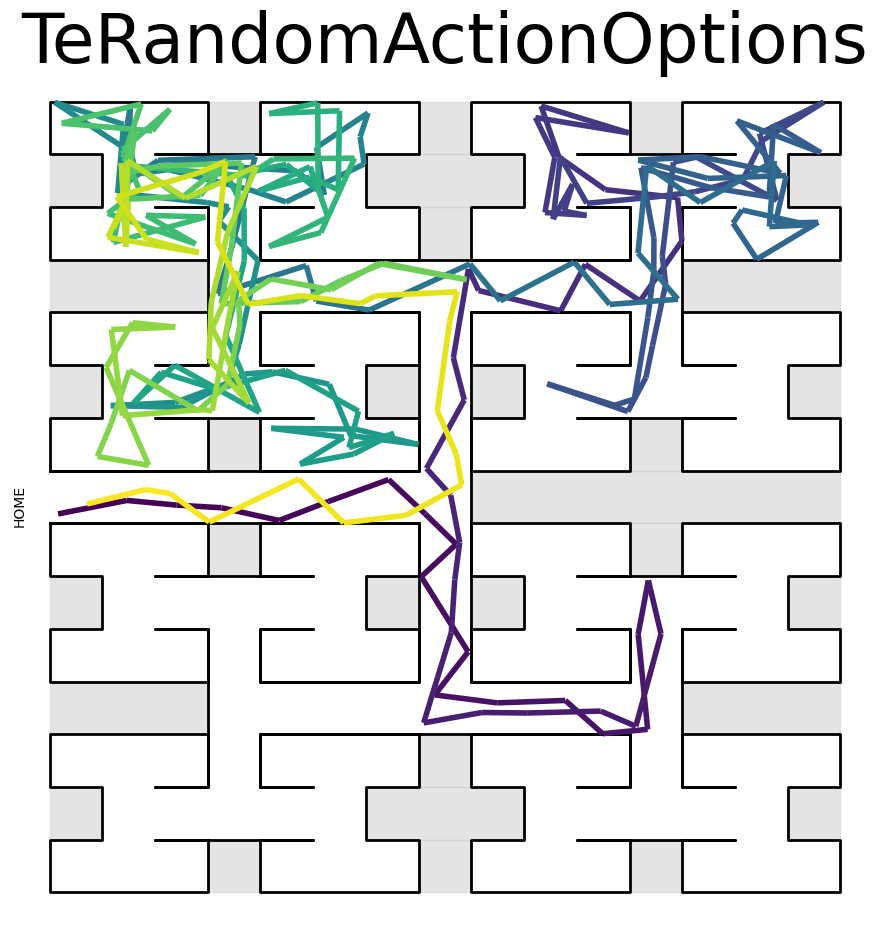

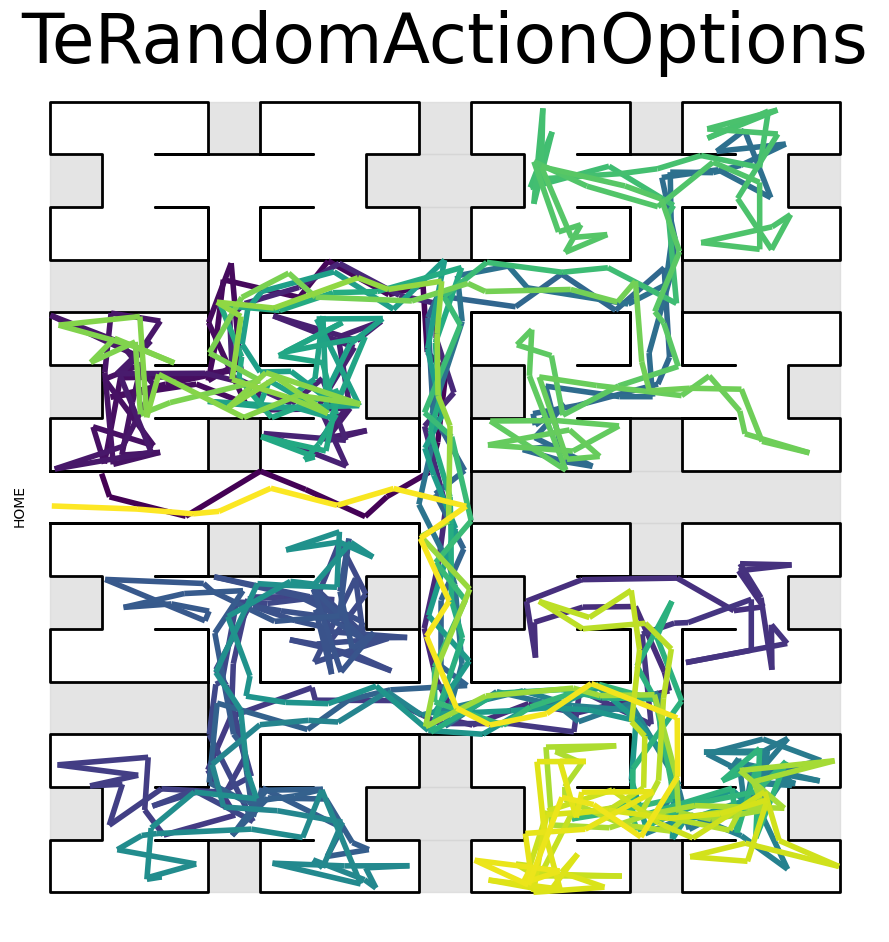

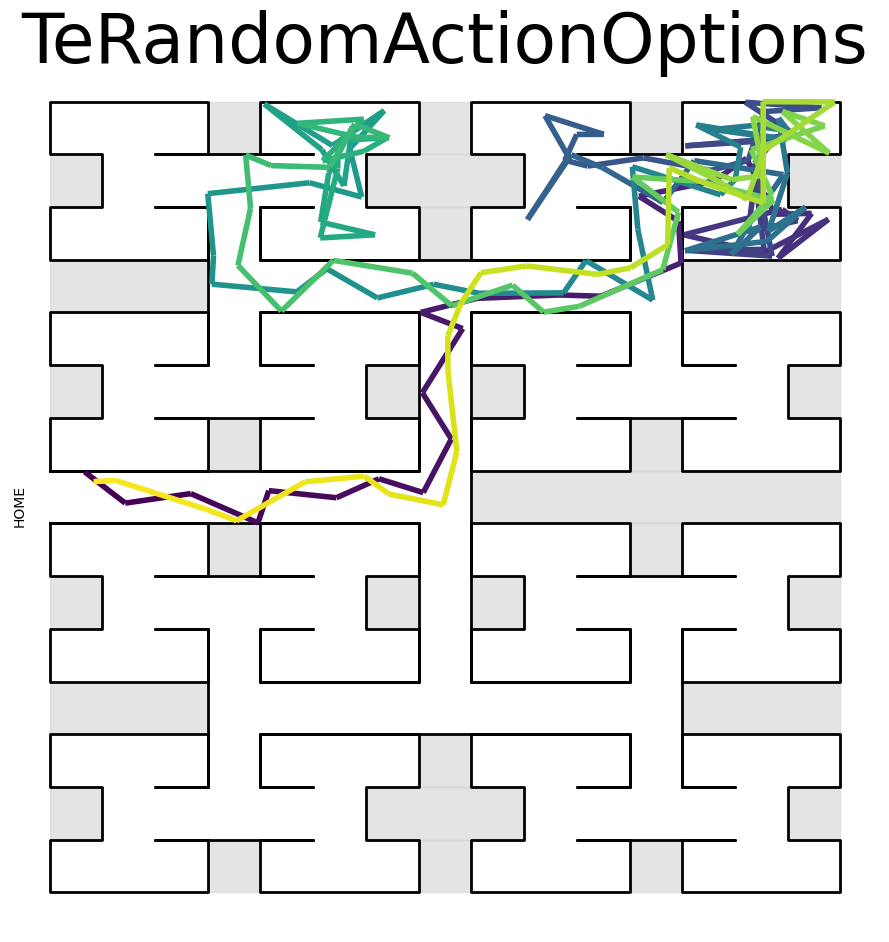

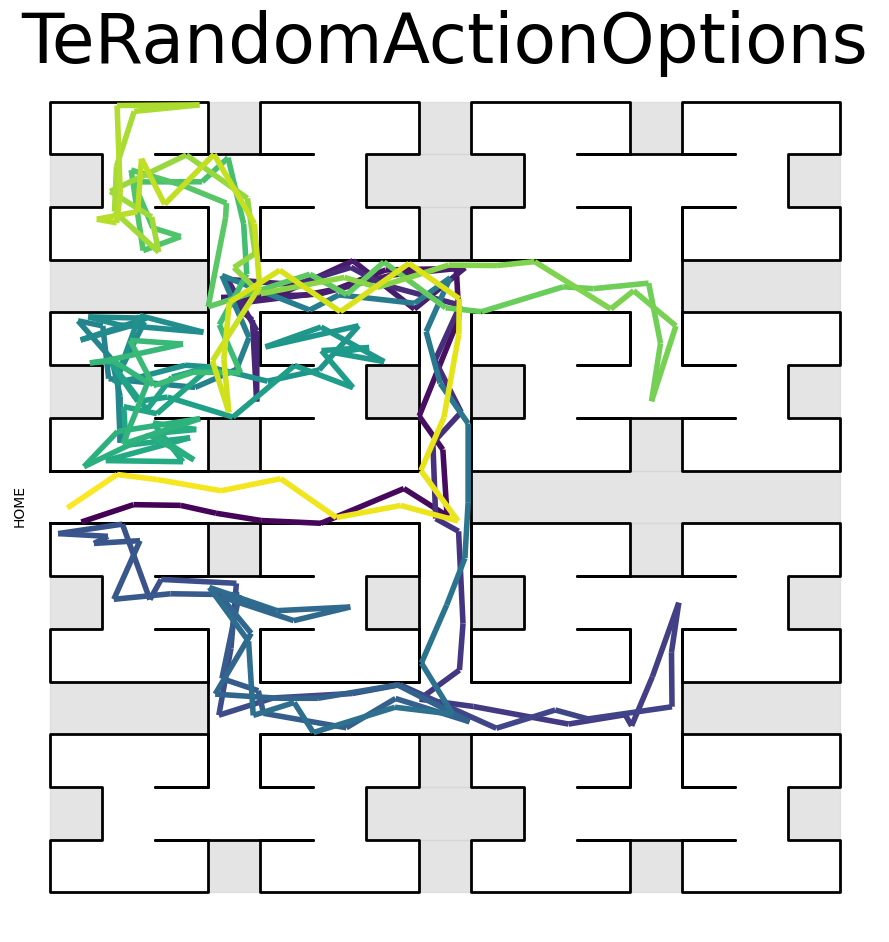

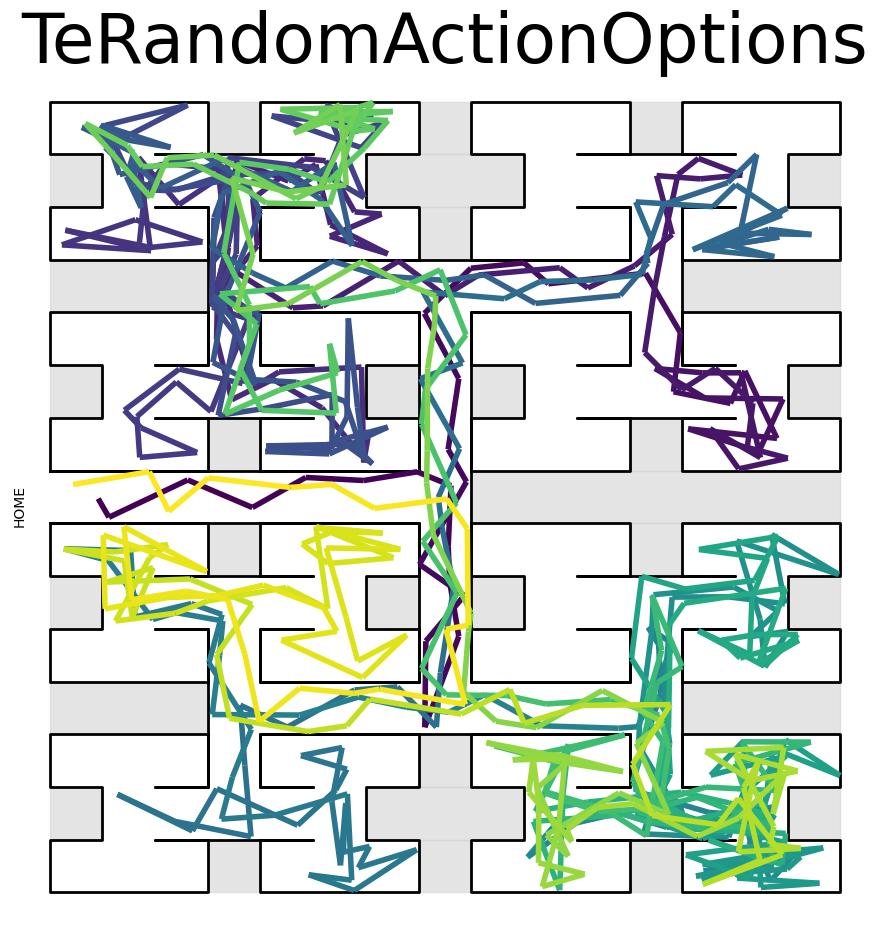

In [336]:
for model_name in ['TeFixedActionOptions', 'TeRandomActionOptions']:
    tf = load(model_name)
    print(f"Generating for {model_name}...")
    lens = np.array([len(_) for _ in tf[0].no])
#     print(lens)
    minlen_tf_idxs = np.where((lens > 150) & (lens < 200))[0]
#     print(minlen_tf_idxs)
    if not minlen_tf_idxs.any():
        print(f"Empty for {model_name}")
        continue
    for i in np.random.choice(minlen_tf_idxs, size=5):
        print(i)
        traj = tf[1].no[i][:, 0]
        plt_trajectory([traj], 'all', 
                       save_file_name=f'/Users/us3519/mouse-maze/figs/paper figs/figure_altoptions/{model_name}/{model_name}_{i}.pdf', 
                       title=f'{model_name}', 
                       entry_exit_colorbar=False, display=False)
    print("=======")